Digital Filter Simulation Notebook

In [8]:
import numpy as np
from scipy import signal


class DigitalFilter:
    def __init__(self, zeros=None, poles=None, gain=1) -> None:
        """
        Initialize the Filter class with zeros, poles, and gain.
        If zeros and poles are not given, they are set to an empty list.
        The default value for gain is 1.
        """
        self.__zeros = zeros if zeros else []
        self.__poles = poles if poles else []
        self.__all_pass = []
        self.__gain = gain

    # Define getters
    def get_zeros(self):
        return self.__zeros[:]

    def get_poles(self):
        return self.__poles[:]

    def get_all_pass(self):
        return self.__all_pass[:]

    # Define setters
    def zeros(self, zeros: list) -> None:
        """
        Set the zeros of the filter.
        """
        self.__zeros = zeros

    def poles(self, poles: list) -> None:
        """
        Set the poles of the filter.
        """
        self.__poles = poles

    def gain(self, gain: float) -> None:
        """
        Set the gain of the filter.
        """
        self.__gain = gain

    # Define instance methods
    def response(self, w=None) -> tuple:
        """
        Get the response of the filter at a given frequency (w).
        If w is not given, compute the response at a range of frequencies.
        Returns a tuple of w (frequency), magnitude, and phase.
        """
        if w is None:
            w, response = signal.freqz_zpk(self.__zeros, self.__poles, self.__gain)
            # `w` is the x_axis from 0 hz to fmax hz (default value normalized from 0 to pi)
            # `response` is the complex output of z_transform where we can get the magnitude & phase
        else:
            response = signal.zpk_eval_response(self.__zeros, self.__poles, self.__gain, w)
        magnitude = 20 * np.log10(np.abs(response))
        # convert from hz into decibels
        phase = np.unwrap(np.angle(response))   # `np.unwrap` to remove phase discontinuities
        return w, magnitude, phase

    def series_all_pass(self, a_list: list):
        """
        Add one or more all-pass filters with coefficient a to the filter.
        """
        self.__all_pass = a_list.copy()
        self.__poles = [*self.__poles, *a_list]
        b = []
        for i in range(len(a_list)):
            b.append(1 / np.conj(a_list[i]))
        self.__zeros = [*self.__zeros, *b]

    def remove_all_pass(self):
        """
        Remove all all-pass filters from the filter.
        """
        self.__zeros = self.__zeros[0:len(self.__zeros) - len(self.__all_pass)]
        self.__poles = self.__poles[0:len(self.__poles) - len(self.__all_pass)]
        self.__all_pass = []

    def one_all_pass(self, a: complex):
        """
        Add one all-pass filter with coefficient a to the filter.
        """
        self.__all_pass.append(a)
        self.__poles.append(a)
        self.__zeros.append(1 / np.conj(a))


In [35]:
import matplotlib.pyplot as plt

zeros_x = [0.3, 0.6]
zeros_y = [0.5, -0.6]
poles_x = [0.1, 0.2]
poles_y = [0.4, -0.5]

filter_1 = DigitalFilter(zeros=[complex(zeros_x[0], zeros_y[0]), complex(zeros_x[1], zeros_y[1])],
                         poles=[complex(poles_x[0], poles_y[0]), complex(poles_x[1], poles_y[1])])

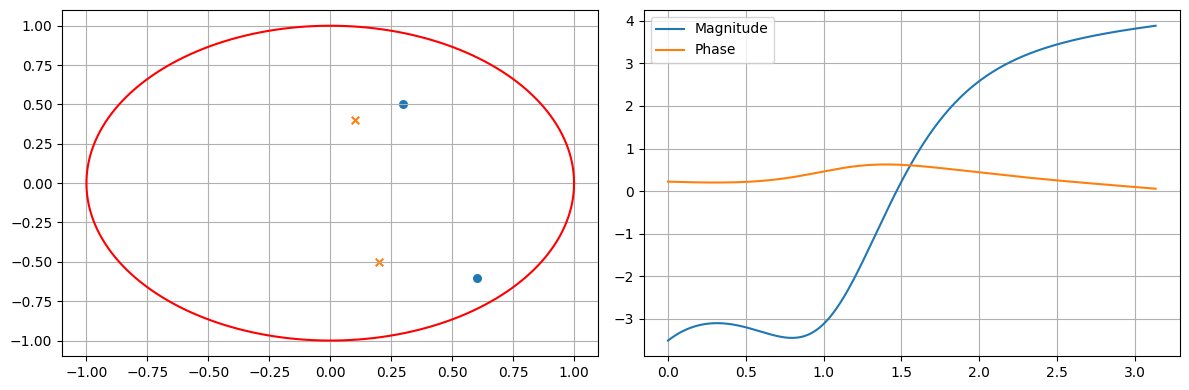

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

a = np.cos(np.linspace(0, 2 * np.pi, 200))
b = np.sin(np.linspace(0, 2 * np.pi, 200))
ax1.scatter(zeros_x, zeros_y, s=30, marker='o')
ax1.scatter(poles_x, poles_y, s=30, marker='x')
ax1.plot(a, b, color="red")
ax1.grid()

w, m, p = filter_1.response()
ax2.plot(w,m, label='Magnitude')
ax2.plot(w,p, label='Phase')
ax2.grid()
ax2.legend()
fig.tight_layout()
plt.show()

In [37]:
filter_1.one_all_pass(complex(-0.1,0))

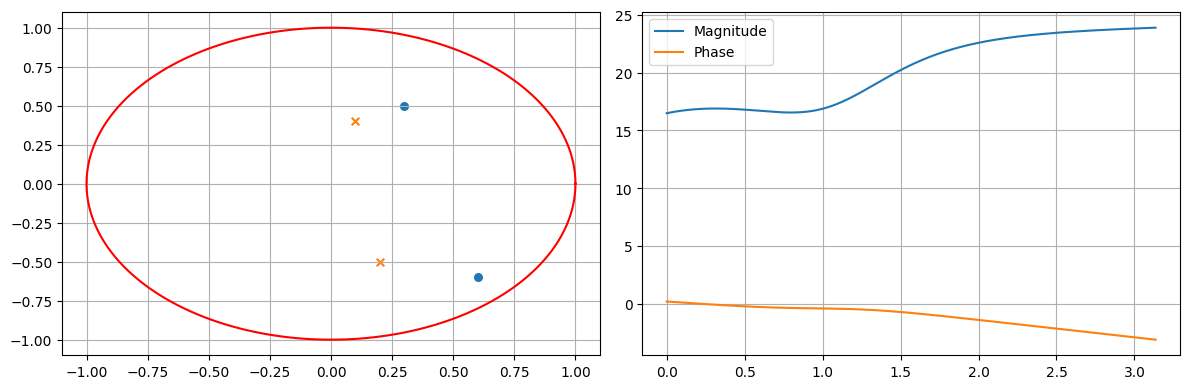

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

a = np.cos(np.linspace(0, 2 * np.pi, 200))
b = np.sin(np.linspace(0, 2 * np.pi, 200))
ax1.scatter(zeros_x, zeros_y, s=30, marker='o')
ax1.scatter(poles_x, poles_y, s=30, marker='x')
ax1.plot(a, b, color="red")
ax1.grid()

w, m, p = filter_1.response()
ax2.plot(w,m, label='Magnitude')
ax2.plot(w,p, label='Phase')
ax2.grid()
ax2.legend()
fig.tight_layout()
plt.show()

In [39]:
filter_1.get_all_pass()

[(-0.1+0j)]

In [40]:
filter_1.get_poles()

[(0.1+0.4j), (0.2-0.5j), (-0.1+0j)]

In [41]:
filter_1.remove_all_pass()

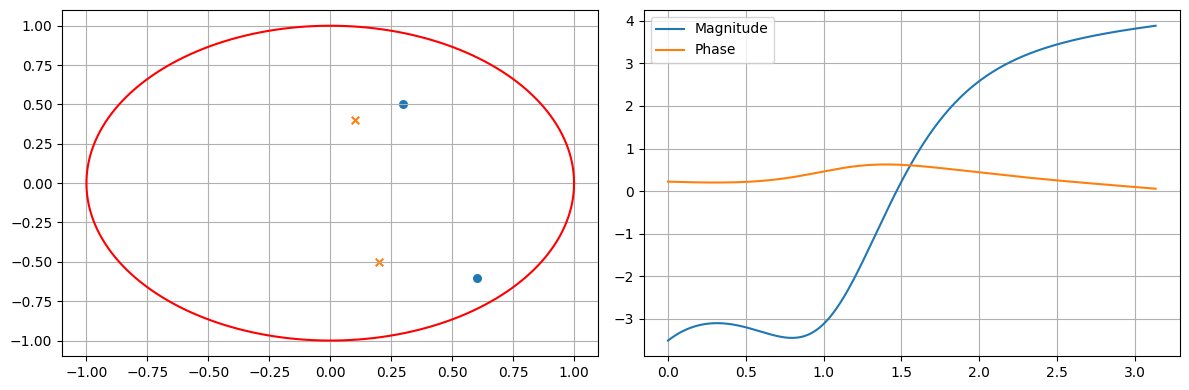

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

a = np.cos(np.linspace(0, 2 * np.pi, 200))
b = np.sin(np.linspace(0, 2 * np.pi, 200))
ax1.scatter(zeros_x, zeros_y, s=30, marker='o')
ax1.scatter(poles_x, poles_y, s=30, marker='x')
ax1.plot(a, b, color="red")
ax1.grid()

w, m, p = filter_1.response()
ax2.plot(w,m, label='Magnitude')
ax2.plot(w,p, label='Phase')
ax2.grid()
ax2.legend()
fig.tight_layout()
plt.show()

In [43]:
filter_1.get_poles()

[(0.1+0.4j), (0.2-0.5j)]

In [1]:
zeros = [{1, 2}, {0.2, 1}]
poles = [{0.1, 2}, {2, 1}]
modified_zeros = []
modified_poles = []

for z in zeros:
    modified_zeros.append(complex(list(z)[0], list(z)[1]))
for p in poles:
    modified_poles.append(complex(list(p)[0], list(p)[1]))

In [2]:
modified_zeros

[(1+2j), (0.2+1j)]